# Reducción de Datos de Goodman High Throughput Spectrograph


Autor: Simón Torres

Fecha: 06 de Mayo de 2020

# Contenido

- Goodman HTS Overview
- La Pipeline de Goodman
- Procesos de Reducion
- Usando la pipeline desde una terminal
- Web App



# Goodman HTS overview

## Links de interes

http://www.ctio.noao.edu/soar/content/goodman-high-throughput-spectrograph


## El Instrumento

Es un _imaging spectrograph_ con un gran rango de resolucion entre 320 a 850 nm disenado para alto rendimiento (baja perdida de luz)

![Rango Espectroscopico](./img/Visible-spectrum.jpg)

Imagenes sacadas de [Clemens et al. (2004)](https://ui.adsabs.harvard.edu/abs/2004SPIE.5492..3)


![Estructura del instrumento](./img/estructura-goodman.png)

![Ensamblado](./img/instrument-assembled.png)

## Algunos conceptos de espectroscopia

![espectroscopia](./img/spectroscopy.png)
![espectroscopia](./img/spectroscopy-colors.jpg)

## Los Datos

Los datos del instrumento se obtienen como imagenes 2D

In [19]:
import os
import numpy as np

from matplotlib import pyplot as plt
from ccdproc import CCDData

from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(ccd, xlabel='', ylabel=''):
    fig, ax = plt.subplots(figsize=(16,9))
    
    z1 = np.mean(ccd.data) - 0.5 * np.std(ccd.data)
    z2 = np.median(ccd.data) + np.std(ccd.data)
    
    
    img = ax.imshow(ccd.data, clim=(z1, z2), cmap='viridis')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    divider = make_axes_locatable(ax)

    cax = divider.append_axes('right', size="3%", pad=0.1)
    plt.colorbar(img, cax=cax)



In [20]:
this_folder = os.getcwd()
relative_data_folder = 'fits/2019-08-06'

Ejemplo de una imagen espectroscopica

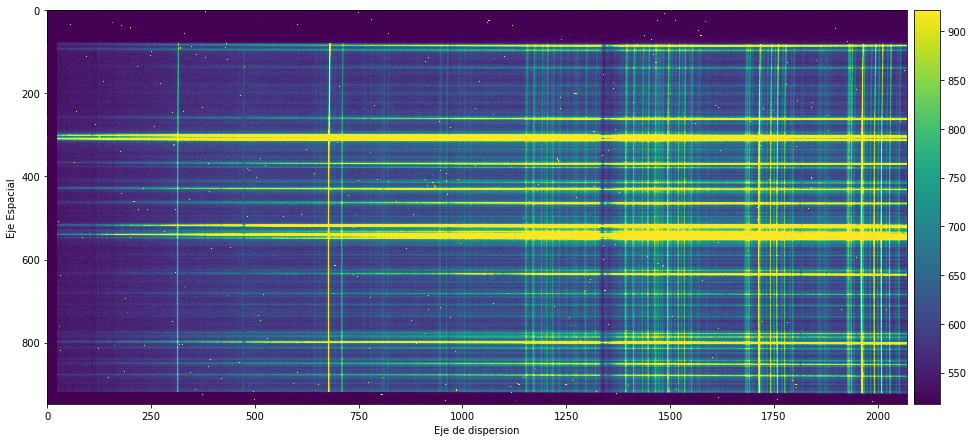

In [22]:
sample_file = '0154_OGLE-2019-BLG-1103-07-08-2019.fits'
full_path = os.path.join(this_folder, relative_data_folder, sample_file)

ccd = CCDData.read(full_path, unit='adu')

plot_image(ccd=ccd, xlabel='Eje de dispersion', ylabel='Eje Espacial')

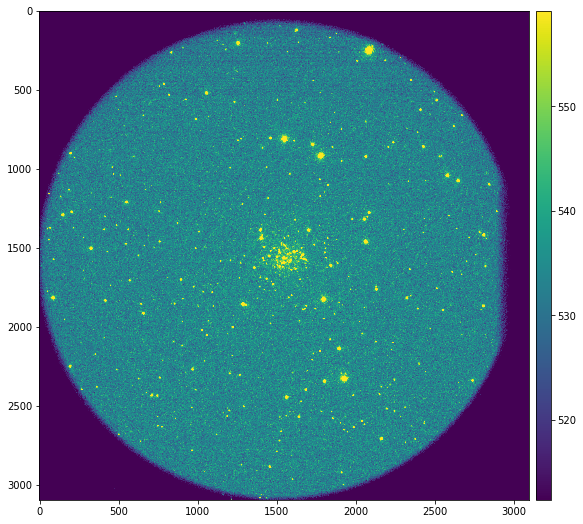

In [23]:
imaging_sample_file = '0238_SO2019B-019.fits'
full_path = os.path.join(this_folder, 'fits/2019-12-20', imaging_sample_file)

ccd_img = CCDData.read(full_path, unit='adu')

plot_image(ccd=ccd_img)

# Goodman Pipeline

Ir a [Documentacion](https://goodman.readthedocs.io/en/latest/index.html)

## Autores

* Simón Torres, Cesar Briceño, PhD., Bruno Quint, PhD., David Sanmartim,PhD. SOAR Telescope, La Serena, Chile.
  - e-mail: storres@ctio.noao.edu or goodman-pipeline@ctio.noao.edu
  - github: simontorres
  
  
## Motivación

- El espectrografo Goodman es el _caballo de batalla_ de SOAR usando ~ 65% del tiempo disponible.
- SOAR Telescope esta planeando convertirse en un telescopio de seguimiento en la era de LSST.
- Usuarios tenían que arreglarselas con sus propias herramientas.
- Astropy es lo más cercano a reemplazar a IRAF.


## Objetivos

- Facil de usar
- Bien documentado
- Programación a la altura de la industria de software (ver [Tecnicas de Desarrollo](https://github.com/simontorres/general_documentation/blob/master/jupyter-notebooks/presentations/Development%20Techniques%20II.ipynb))
  - Guía de estilo y de documentación (PEP 8, 257)
  - Unittest (Travis CI.)
  - Control de version (git+GitHub)
- Que produzca datos science-ready
- Programada 100% en Python
  - Usar lo máximo de Astropy como sea posible.
  
## Características Principales

- Dos scripts: `redccd` y `redspec`
- Estructurado como un paquete con 5 subpaquetes.
  - No "sub-subpackages"
- Automática
  - Clasificación de los datos.
  - Calibración de la solución de longitud de onda.
- En menos de 5 minutos podría tener una noche completamente procesada.
  - Desde datos en bruto a calibrados por longitud de onda.
  - Asumiendo que se observó de forma consistente, problema _eliminado_ con AEON.


# Pasos de la reducción

La _Pipeline_ divide el proceso en dos. Primero se hace la reducción estandar de imagen 2D y que es común para _Imaging_ y _Spectroscopy_ aunque no exactamente.

Para un ejemplo bien detallado revisar este [Jupyter Notebook](https://github.com/simontorres/general_documentation/blob/master/jupyter-notebooks/pipeline_development/Transition_to_live_reduction.ipynb) 


## Primera Parte (redccd)

Calibraciones (BIAS, FLAT):

    - Combinar imagenes de BIAS para crear *Master Bias*
    - Corregir imagenes FLAT por BIAS y combinar para crear *Master Flat*
    - Normalizar *Master Flat*.
    
Datos de Ciencia (OBJECT, COMP):

    - Corregir por overscan (opcional, solo Spectrosocopy)
    - Corregir por Master Bias
    - Recortar por TRIMSEC (tambien se debe recortar el master flat)
    - Identificar y recortar zona iluminada por la slit.
    - Aplicar el mismo recorte a los Master Flats
    - Corregir por master flats
    - Limpieza de rayos cósmicos.
    - Combinar imagenes para mejorar señal a ruido.

## Segunda Parte (redspec)

    - Identificar targets
    - Trazar
    - Extraer
    - Calibrar por longitud de onda
    - (Calibrar por Flujo)

# Goodman Pipeline desde una terminal

Es recomendable usar un _ambiente virtual_ uno de los administradores mas populares es _anaconda_ (astroconda channel).

## Instalación

Asumiendo que ya tienen un ambiente virtual creado o al menos instalado astroconda,  ejecutar los siguientes comandos:

Crear un directorio fácil de recordar que se debe borrar y moverse a el.

```
cd ~
mkdir pipeline
cd pipeline
```

Luego clonamos el repositorio con git:

```
git clone https://github.com/soar-telescope/goodman_pipeline.git
```
Y nos movemos al directorio

```
cd goodman_pipeline
```

deberiamos encontrar lo siguiente:

```
drwxrwxr-x 6 simon simon 4096 may  5 22:40 .
drwxrwxr-x 3 simon simon 4096 may  5 22:38 ..
-rw-rw-r-- 1 simon simon   93 may  5 22:40 CHANGES.md
drwxrwxr-x 4 simon simon 4096 may  5 22:40 dev-tools
drwxrwxr-x 5 simon simon 4096 may  5 22:40 docs
-rw-rw-r-- 1 simon simon  262 may  5 22:40 environment.yml
drwxrwxr-x 8 simon simon 4096 may  5 22:40 .git
-rw-rw-r-- 1 simon simon  169 may  5 22:40 .gitignore
drwxrwxr-x 8 simon simon 4096 may  5 22:40 goodman_pipeline
-rwxrwxr-x 1 simon simon 1175 may  5 22:40 install_dcr.sh
-rw-rw-r-- 1 simon simon 1514 may  5 22:40 LICENSE
-rw-rw-r-- 1 simon simon 3964 may  5 22:40 README.md
-rw-rw-r-- 1 simon simon  234 may  5 22:40 .readthedocs.yml
-rw-rw-r-- 1 simon simon  146 may  5 22:40 requirements.txt
-rw-rw-r-- 1 simon simon  806 may  5 22:40 setup.cfg
-rw-rw-r-- 1 simon simon 4695 may  5 22:40 setup.py
-rw-rw-r-- 1 simon simon 2009 may  5 22:40 .travis.yml
```

Crear un virtual environment usando la definicion provista en `environment.yml`.

```
conda env create -f environment.yml

```
Esto creará un ambiente virtual llamado `goodman_pipeline` se activa con:

```
conda activate goodman_pipeline

```


Ejecutamos el script `install_dcr.sh` ([DCR](http://users.camk.edu.pl/pych/DCR/) es un programa para corrección de rayos cosmicos, by Wojtek Pych)

```
sh ./install_dcr.sh
```

Probamos con 
```
dcr
```

Si no se muestra un error entonces funcionó.

Podemos correr los tests

```
python setup.py test

```

E instalamos con el siguiente comando.

```
python setup.py install
```

Opcionalmente tambien se puede instalar con pip, 
pero no instala dcr, si ya tienen dcr instalado y quieren instalar la ultima version pueden hacer.

```
pip install goodman-pipeline
```

## redccd

Como ya hemos visto `redccd` se encarga de la primera parte de la reducción para espectroscopía.

Con `redccd -h` podemos obtener ayuda.

```
usage: redccd [-h] [--auto-clean] [--cosmic <method>] [--combine]
              [--dcr-par-dir <dcr.par_directory>] [--debug]
              [--flat-normalize <normalization_method>]
              [--flat-norm-order <order>] [--ignore-bias] [--ignore-flats]
              [--keep-cosmic-files] [--raw-path <raw_path>]
              [--red-path <red_path>] [--saturation_threshold <value>]
              [--version]

Goodman CCD Reduction - CCD reductions for Goodman spectroscopic data.
Pipeline Version: 1.3.0

optional arguments:
  -h, --help            show this help message and exit
  --auto-clean          Automatically clean reduced data directory
  --cosmic <method>     Clean cosmic rays from all data. Options are:
                        'default', 'dcr', 'lacosmic' or 'none'. See manual for
                        full description of dcr.
  --combine             Combine compatible data (experimental)
  --dcr-par-dir <dcr.par_directory>
                        Directory of default dcr.par file
  --debug               Show detailed information of the process.
  --flat-normalize <normalization_method>
                        Choose a method to normalize the master flat for
                        spectroscopy. Choices are: 'mean','simple' (model) and
                        'full' (fits model to each line). Default 'simple'
  --flat-norm-order <order>
                        Defines the order of the model to be fitted. Default
                        to 15
  --ignore-bias         Ignore bias correction
  --ignore-flats        Ignore flat field correction
  --keep-cosmic-files   After cleaning cosmic rays with 'dcr', do not remove
                        the input file and the cosmic rays file. For
                        'lacosmic' it saves the mask to a fits file.
  --raw-path <raw_path>
                        Path to raw data.
  --red-path <red_path>
                        Path to reduced data.
  --saturation_threshold <value>
                        Maximum percent of pixels above saturation_threshold
                        threshold. Default 1 percent.
  --version             Show current version of the Goodman Pipeline
```

## redspec

Para espectroscopia tenemos que seguir con el siguiente paso. Nuevamente on `redspec -h` obtenemos ayuda.


```
usage: redspec [-h] [--data-path <Source Path>]
               [--proc-path <Destination Path>]
               [--search-pattern <Search Pattern>]
               [--output-prefix <Out Prefix>] [--extraction <Extraction Type>]
               [--fit-targets-with {moffat,gaussian}]
               [--reference-files <Reference Dir>] [--debug] [--debug-plot]
               [--max-targets <max targets>]
               [--background-threshold BACKGROUND_THRESHOLD] [--save-plots]
               [--plot-results] [--version]

Extracts goodman spectra and does automatic wavelength calibration. Pipeline
Version: 1.3.0

optional arguments:
  -h, --help            show this help message and exit
  --data-path <Source Path>
                        Path for location of raw data. Default <./>
  --proc-path <Destination Path>
                        Path for destination of processed data. Default <./>
  --search-pattern <Search Pattern>
                        Pattern for matching the goodman's reduced data.
  --output-prefix <Out Prefix>
                        Prefix to add to calibrated spectrum.
  --extraction <Extraction Type>
                        Method to perform extraction. 'fractional' or
                        'optimal'. Only fractional pixel extraction is
                        implemented. Default 'fractional'.
  --fit-targets-with {moffat,gaussian}
                        Model to fit peaks found on spatial profile while
                        searching for spectroscopic targets.
  --reference-files <Reference Dir>
                        Directory of Reference files location
  --debug               Debugging Mode
  --debug-plot          Debugging show debugging plots
  --max-targets <max targets>
                        Maximum number of targets to be found in a single
                        image. Default 3
  --background-threshold BACKGROUND_THRESHOLD
                        Multiplier for background level used to discriminate
                        usable targets. Default 3 times background level
  --save-plots          Save all plots in a directory
  --plot-results        Show wavelength calibrated spectrum at the end.
  --version             Show current version of the Goodman Pipeline
```

Uno de los argumentos utiles serian `--debug` y `--debug-plot` en caso que no este claro de porque algun target no fue extraido o detectado.


# Web App

http://soarvm2.ctio.noao.edu


![webapp](./img/webapp_1.png)
![webapp](./img/webapp_2.png)
![webapp](./img/webapp_3.png)
![webapp](./img/webapp_4.png)
![webapp](./img/webapp_5.png)

In [49]:
!gnome-terminal